# GCC's ssc-cdi : Restoration Interface for Cateretê, v0.0.1
 
- #### To visualize outputs in real time, open the log console at: View > Show Log Console
- #### Questions? E-mail gcc@lnls.br

In [10]:
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import fixed
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm
from sscCdi import jupyter
from sscCdi.caterete.ptycho_restauration import restauration_processing_binning
import json
import os
import h5py
from sscIO import io
from sscPimega import pi540D

def Geometry(L):
    project = pi540D.get_detector_dictionary( L, {'geo':'nonplanar','opt':True,'mode':'virtual'} ) 
    geo = pi540D.geometry540D( project )
    return geo

def restoration_via_interface(data_path,inputs,apply_flat=True,apply_empty=True,apply_mask=True, save_data=True, preview=True):
    
    metadata = json.load(open(os.path.join(data_path.rsplit('/',2)[0],'mdata.json')))
    empty_path = os.path.join(data_path.rsplit('/',2)[0],'images','empty.hdf5')
    flat_path = os.path.join(data_path.rsplit('/',2)[0],'images','flat.hdf5')
    mask_path = os.path.join(data_path.rsplit('/',2)[0],'images','mask.hdf5')    
    distance = float(metadata['/entry/beamline/experiment']["distance"])

    """ Get detector geometry from distance """
    geometry = Geometry(distance)
    
    n_of_threads, centerx, centery = inputs

    L = 3072 # PIMEGA540D size
    half_square_side = min(min(centerx,L-centerx),min(centery,L-centery)) # get the biggest size possible such that the restored difpad is still squared

    os.system(f"h5clear -s {data_path}") # gambiarra because file is not closed at the backend!
    os.system(f"h5clear -s {empty_path}") # gambiarra because file is not closed at the backend!

    raw_difpads,_ = io.read_volume(data_path, 'numpy', use_MPI=True, nprocs=n_of_threads)
    print("\tRaw data shape: ", raw_difpads.shape)
    
    """ SIMPLE RESTORATION PRIOR TO CENTER SELECTION. USED TO FIND CENTER """
    restored_full_DP = Restaurate(raw_difpads[0,:,:].astype(np.float32), geometry) # restaurate
    
    """ How the corrections are made prior to restoration:
    
        img[empty > 1] = -1 # Apply empty 
        img = img * np.squeeze(flat) # Apply flatfield
        img[np.abs(mask) ==1] = -1   # Apply Mask
        img = img[cy - hsize:cy + hsize, cx - hsize:cx + hsize] # Center data

    """
    if apply_empty:
        empty = np.asarray(h5py.File(empty_path, 'r')['/entry/data/data']).squeeze().astype(np.float32)
    else:
        empty = np.zeros_like(raw_difpads[0])

    if apply_flat:
        flat = np.array(h5py.File(flat_path, 'r')['entry/data/data'][()][0, 0, :, :])
        flat[np.isnan(flat)] = -1
        flat[flat == 0] = 1
    else:
        flat = np.ones_like(raw_difpads[0])
    
    if apply_mask:
        mask = h5py.File(mask_path, 'r')['entry/data/data'][()][0, 0, :, :]
    else:
        mask  = np.zeros_like(raw_difpads[0])

    
    if preview:
        img = np.ones_like(mask)
        plot1, plot2, plot3 = empty, flat, mask
        empty = np.asarray(h5py.File(empty_path, 'r')['/entry/data/data']).squeeze().astype(np.float32)
        flat = np.array(h5py.File(flat_path, 'r')['entry/data/data'][()][0, 0, :, :])
        flat[np.isnan(flat)] = -1
        flat[flat == 0] = 1
        mask = h5py.File(mask_path, 'r')['entry/data/data'][()][0, 0, :, :]

        img[empty > 1] = -1 # Apply empty 
        img = img * np.squeeze(flat) # Apply flatfield
        img[np.abs(mask) ==1] = -1   # Apply Mask

        fig, ax = plt.subplots(1,4,figsize=(15,5))
        ax[0].imshow(plot1), ax[0].set_title('empty')
        ax[1].imshow(plot2), ax[1].set_title('flat')
        ax[2].imshow(plot3), ax[2].set_title('mask')
        ax[3].imshow(img),   ax[3].set_title('all')        
        plt.show()    
        
    Binning = 4 # standard is 4 for now



    jason = {} # dummy dictionary with dummy values to be used within restoration function 
    jason["DetectorExposure"] = [False,0.15]
    jason["CentralMask"] = [False,5]
    jason["DifpadCenter"] = [centery, centerx]
    
    """ Call corrections and restoration """
    print("Correcting and restoring diffraction patterns... ")
    r_params = (Binning, empty, flat, centerx, centery, half_square_side, geometry, mask, jason)
    output, _ = pi540D.backward540D_nonplanar_batch(raw_difpads, distance, n_of_threads, [ half_square_side//2 , half_square_side//2 ], restauration_processing_binning,  r_params, 'only') # Apply empty, flatfield, mask and restore!
    print("\tRestored data shape: ", output.shape)

    if save_data:
        savepath = os.path.join(data_path.rsplit('/',5)[0],'proc','recons',data_path.rsplit('/',3)[-3],'restoration',data_path.rsplit('/',2)[-1])
        if not os.path.exists(savepath.rsplit('/',1)[0]):
            os.makedirs(savepath.rsplit('/',1)[0])
        print("Saving data at: ",savepath)
        h5f = h5py.File(savepath, 'w')
        h5f.create_dataset(data_path.rsplit('/',2)[-1][:-5], data=output)
        h5f.close()

    print("Done!")

    return output, restored_full_DP


def plot_DPs_with_slider(data,axis=0):

    colornorm=colors.Normalize(vmin=data.min(), vmax=data.max())
    cmap = 'viridis'
    
    def update_imshow(sinogram,figure,subplot,frame_number,top=0, bottom=None,left=0,right=None,axis=0,title=False,clear_axis=False,cmap=cmap,norm=colors.LogNorm()):
        subplot.clear()
        if bottom == None or right == None:
            if axis == 0:
                subplot.imshow(sinogram[frame_number,top:bottom,left:right],cmap=cmap,norm=norm)
            elif axis == 1:
                subplot.imshow(sinogram[top:bottom,frame_number,left:right],cmap=cmap,norm=norm)
            elif axis == 2:
                subplot.imshow(sinogram[top:bottom,left:right,frame_number],cmap=cmap,norm=norm)
        else:
            if axis == 0:
                subplot.imshow(sinogram[frame_number,top:-bottom,left:-right],cmap=cmap,norm=norm)
            elif axis == 1:
                subplot.imshow(sinogram[top:-bottom,frame_number,left:-right],cmap=cmap,norm=norm)
            elif axis == 2:
                subplot.imshow(sinogram[top:-bottom,left:-right,frame_number],cmap=cmap,norm=norm)
        if title == True:
            subplot.set_title(f'#{frame_number}')
        if clear_axis == True:
            subplot.set_xticks([])
            subplot.set_yticks([])    
        figure.canvas.draw_idle()
    
    output = widgets.Output()
    
    with output:
        figure, ax = plt.subplots(dpi=150)
        figure.canvas.draw_idle()
        figure.canvas.header_visible = False
        figure.colorbar(matplotlib.cm.ScalarMappable(norm=colornorm, cmap=cmap))
        plt.show()   

    play_box, selection_slider,play_control = jupyter.slide_and_play(label="Frame Selector",frame_time_milisec=300)

    selection_slider.widget.max, selection_slider.widget.value = data.shape[0] - 1, data.shape[0]//2
    play_control.widget.max =  selection_slider.widget.max
    widgets.interactive_output(update_imshow, {'sinogram':fixed(data),'figure':fixed(figure),'title':fixed(True),'subplot':fixed(ax),'axis':fixed(axis), 'norm':fixed(colors.LogNorm()),'frame_number': selection_slider.widget})    
    box = widgets.VBox([play_box,output])
    return box

def Restaurate(img, geom):
    return pi540D.backward540D(img, geom)

def plot_flipped_full_DP(restored_full_DP):
    import matplotlib.pyplot as plt
    from matplotlib.colors import LogNorm
    fig, ax = plt.subplots(dpi=150)
    ax.imshow(restored_full_DP,norm=LogNorm()), ax.set_title("Average of DPs")

## Inputs

In [8]:
data_path = "/ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/data/ptycho2d/SS61/scans/0000_SS61_001.hdf5"
n_of_threads = 100
center_x = 1340
center_y = 1380

## Process Data

Reading raw data from:  /ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/data/ptycho2d/SS61/scans/0000_SS61_001.hdf5
-- Calling MPI code to read /ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/data/ptycho2d/SS61/scans/0000_SS61_001.hdf5
	Raw data shape:  (625, 3072, 3072)


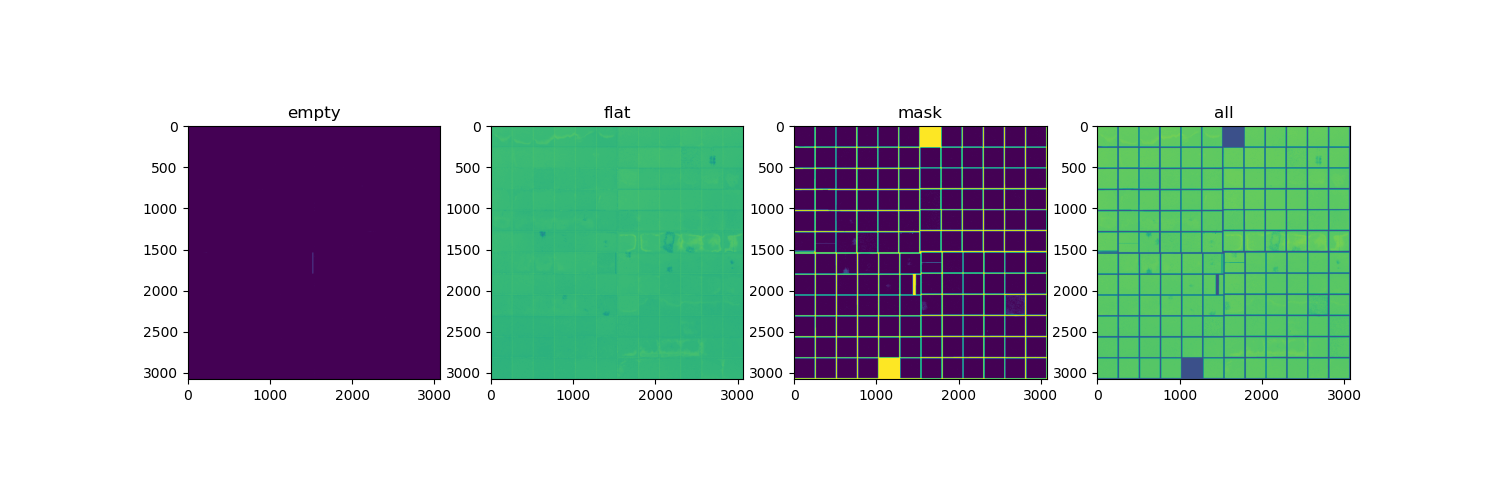

Correcting and restoring diffraction patterns... 
sscPimega: creating 625x670x670 shared array (SharedArray)
Done: 625 Images corrected within 44.344918727874756 sec
    :    Shared Array creation 0.00028634071350097656 sec
	Restored data shape:  (625, 670, 670)
Saving data at:  /ibira/lnls/beamlines/caterete/apps/gcc-jupyter/00000000/proc/recons/SS61/restoration/0000_SS61_001.hdf5
Done!


In [9]:
processed_data, restored_full_DP = restoration_via_interface(data_path,[n_of_threads,center_x,center_y])

## Find center

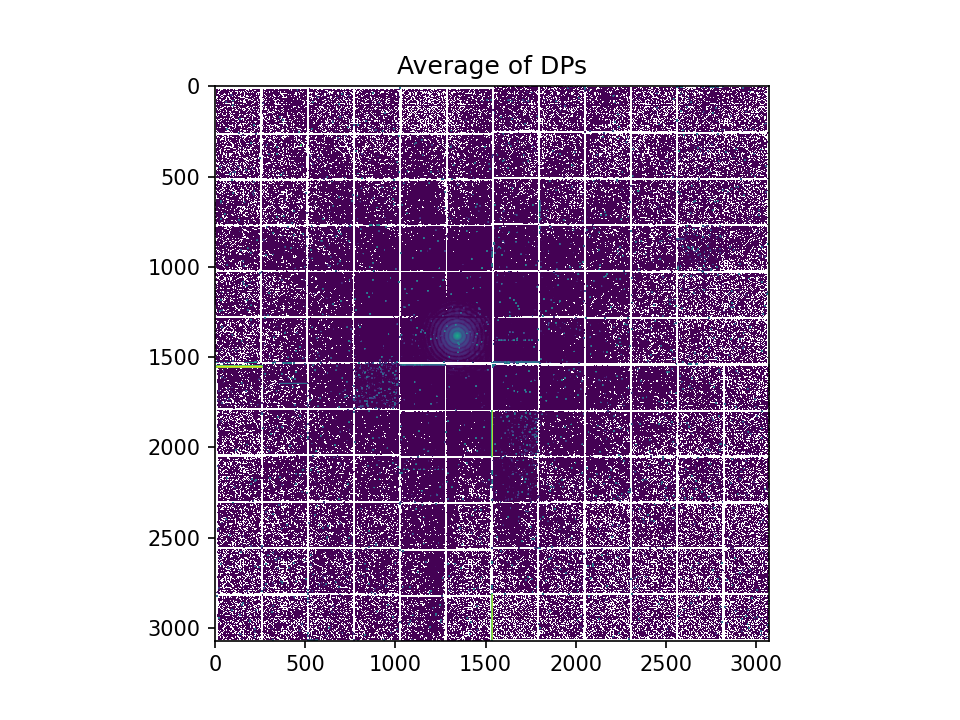

In [11]:
plot_flipped_full_DP(restored_full_DP)

## View processed data

In [12]:
plot_DPs_with_slider(processed_data)